# Winton Stock Market Analysis

In [17]:
%pylab inline
import numpy as np
import tensorflow as tf
import pandas as pd

from keras import backend as K
from keras.models import Sequential, Input, Model
from keras.layers import LSTM, Dense, Reshape, Activation
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

from IPython.display import display
from pprint import pprint as pp
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data Preprocessing

| Column | Index | train | Desciption |
|:-------|:-----:|:-----:|:-----------|
| Feature_1 | 0 | O | feature 첫번째 - 주가 예측에 영향을 주는 부분 |
| Feature_25 | 24 | O | feature 마지막 - 주가 예측에 영향을 주는 부분 | 
| Ret_MinusTwo | 25 | O | D-2의 폐장시점부터 D1의 폐장시점까지의 수익률입니다. (1 day) |
| Ret_MinusOne | 26 | O | D-1의 폐장시점부터 D의 일중 변동(Intraday returns)전까지의 수익률입니다. (대략 1/2 day) |
| Ret_2 | 27 | O | intraday 첫번째 - D의 특정시점의 대략적인 분단위 수익률입니다. Ret_2의 경우 t=1 과 t=2사이의 수익률입니다. |
| Ret_120 | 145 | O | intraday 마지막 - D의 특정시점의 대략적인 분단위 수익률입니다. Ret_2의 경우 t=1 과 t=2사이의 수익률입니다. | 
| Ret_121 | 146 | X | intraday 분단위 수익률 시작점 | 
| Ret_180 | 205 | X | intraday 분단위 수익률 마지막 | 
| Ret_PlusOne | 206 | X | Ret_180이 계산 종료된 시점부터 D+1의 폐장시점까지의 수익률입니다 (대략 1 day) |
| Ret_PlusTwo | 207 | X |  D+1의 폐장시점부터 D+2의 폐장시점까지의 수익률입니다. (1 day) |
| Weight_Intraday | 208 | X |  Ret_121 부터 Ret_180 까지의 일중 수익률을 계산시 사용한 가중치(weight)입니다. |
| Weight_Daily | 209 | X |   Ret_PlusOne 그리고 Ret_PlusTwo를 예측할때 사용한 가중치 (Weight)입니다. |
| trend_2 | 210 | O |   Ret_2의 cumsum |
| trend_120 | 328 | O |   Ret_120의 cumsum |
| trend_121 | 329 | X |   Ret_121의 cumsum |
| trend_180 | 388 | X |   Ret_180의 cumsum |
| padded_intraday_y_0 | 389 | X |   Padded된 intraday y 처음값 |
| padded_intraday_y_118 | 507 | X |   Padded된 intraday y 마지막값 |
| padded_trend_0 | 508 | X |  Padded된 trend y 처음값 |
| padded_trend_0 | 626 | X |  Padded된 trend y 처음값 |

In [2]:
train_raw = pd.read_csv('/dataset/winton-stock-market-challenge/train.csv')
# test_raw = pd.read_csv('/dataset/winton-stock-market-challenge/test.csv')

In [3]:
FEATURE_INDICES = list(range(0, 25))
RET_MINUS_TWO = [25]
RET_MINUS_ONE = [26]
INTRADAY_X = list(range(27, 146))
INTRADAY_Y = list(range(146, 206))
INTRADAYS = INTRADAY_X + INTRADAY_Y

RET_PLUS_ONE = [206]
RET_PLUS_TWO = [207]
TREND_X = list(range(210, 329))
TREND_Y = list(range(329, 389))

PADDED_INTRA_Y = list(range(389, 389+len(INTRADAY_X)))
PADDED_TREND_Y = list(range(508, 508+len(TREND_X)))

### Processing NAN & Dropping Useless Columns
먼저 nan을 처리하고, 필요 없는 columns (Id) 를 제거합니다.

In [4]:
def preprocess_nan(raw_data):
    data = raw_data.fillna(0)
    data = data.drop(['Id'], axis=1)
    return data

data = preprocess_nan(train_raw)

## Scaling

In [5]:
# Feature Scaling for Training Data
feature_scaler = StandardScaler()
data[FEATURE_INDICES] = feature_scaler.fit_transform(data[FEATURE_INDICES])

### Calculate Trend  (Cumulative Sum)

Intraday returns (Ret_2 부터 Ret_180)의 cumulative sum을 구합니다. 

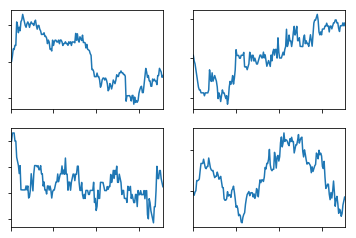

In [6]:
# Cumulative Sum Intraday returns
data[[f'cum_{i}' for i in range(2, len(INTRADAYS)+2)]] = data[INTRADAYS].cumsum(axis=1)

# Visualization
f, ((ax1, ax2), (ax3, ax4))= subplots(2, 2)

ax1.tick_params(labelbottom='off', labelleft='off')
ax2.tick_params(labelbottom='off', labelleft='off')
ax3.tick_params(labelbottom='off', labelleft='off')
ax4.tick_params(labelbottom='off', labelleft='off')

def _p(ax): 
    data[TREND_X + TREND_Y].iloc[np.random.randint(1000)].plot(ax=ax)
    
_p(ax1); _p(ax2); _p(ax3); _p(ax4)

### Padding for LSTM

In [7]:
def padding(data, maxlen, prefix):
    _padded_data = pad_sequences(data.as_matrix(), 
                                 maxlen=maxlen, 
                                 padding='post', 
                                 dtype='float32')

    _padded_data = pd.DataFrame(_padded_data, 
                                columns=[f'{prefix}{i}' for i in range(_padded_data.shape[1])])
    return _padded_data
    

_padded_intra_y = padding(data[INTRADAY_Y], maxlen=len(INTRADAY_X), prefix='PADDED_INTRA_Y_')
_padded_trend_y = padding(data[TREND_Y], maxlen=len(TREND_X), prefix='PADDED_TREND_Y_')

data = pd.concat([data, _padded_intra_y, _padded_trend_y], axis=1)

### Separate Training set and Test set

In [8]:
###########
# Dataframe to Numpy Matrix
###########
data_features = data[FEATURE_INDICES + RET_MINUS_ONE + RET_MINUS_TWO].as_matrix()

data_trend_x = data[TREND_X].as_matrix()
data_trend_y = data[TREND_Y].as_matrix()
data_padded_trend_y = data[PADDED_TREND_Y].as_matrix()

data_intraday_x = data[INTRADAY_X].as_matrix()
data_intraday_y = data[INTRADAY_Y].as_matrix()
data_padded_intraday_y = data[PADDED_INTRA_Y].as_matrix()

###########
# Reshape & Repeat
###########

# 여기서 features는 동일한 27 length vector 119개를 갖은 time-series data로 변신
data_features = data_features.repeat(119, axis=0).reshape((-1, 119, data_features.shape[1]))

data_trend_x = data_trend_x.reshape((-1, data_trend_x.shape[1], 1))
data_trend_y = data_trend_y.reshape((-1, data_trend_y.shape[1], 1))
data_padded_trend_y = data_padded_trend_y.reshape((-1, data_padded_trend_y.shape[1], 1))

data_intraday_x = data_intraday_x.reshape((-1, data_intraday_x.shape[1], 1))
data_intraday_y = data_intraday_y.reshape((-1, data_intraday_y.shape[1], 1))
data_padded_intraday_y = data_padded_intraday_y.reshape((-1, data_padded_intraday_y.shape[1], 1))

data_x = np.append(data_trend_x, data_features, axis=-1)

###########
# Split Data into train and test subsets
###########
TRAIN_SIZE = 0.8
train_features, test_features = train_test_split(data_features, train_size=TRAIN_SIZE)
train_intraday_x, test_intraday_x = train_test_split(data_intraday_x, train_size=TRAIN_SIZE)
train_intraday_y, test_intraday_y = train_test_split(data_intraday_y, train_size=TRAIN_SIZE)
train_padded_intraday_y, test_padded_intraday_y = train_test_split(data_padded_intraday_y, train_size=TRAIN_SIZE)

train_trend_x, test_trend_x = train_test_split(data_trend_x, train_size=TRAIN_SIZE)
train_trend_y, test_trend_y = train_test_split(data_trend_y, train_size=TRAIN_SIZE)
train_padded_trend_y, test_padded_trend_y = train_test_split(data_padded_trend_y, train_size=TRAIN_SIZE)

train_x, test_x = train_test_split(data_x, train_size=TRAIN_SIZE)


###########
# SHAPE
###########
print('[Data]')
print('features:\t', data_features.shape)
print('intraday_x:\t', data_intraday_x.shape)
print('intraday_y(pad):', data_padded_intraday_y.shape)
print('intraday_y:\t', data_intraday_y.shape)
print('trend_x:\t', data_trend_x.shape)
print('trend_y(pad):\t', data_padded_trend_y.shape)
print('trend_y:\t', data_trend_y.shape)
print('x (trend+feat):\t', data_x.shape)

print()
print('[TRAIN]')
print('features:\t', train_features.shape)
print('intraday_x:\t', train_intraday_x.shape)
print('intraday_y(pad):', train_padded_intraday_y.shape)
print('intraday_y:\t', train_intraday_y.shape)
print('trend_x:\t', train_trend_x.shape)
print('trend_y(pad):\t', train_padded_trend_y.shape)
print('trend_y:\t', train_trend_y.shape)
print('x (trend+feat):\t', train_x.shape)

print()
print('[TEST]')
print('features:\t', test_features.shape)
print('intraday_x:\t', test_intraday_x.shape)
print('intraday_y(pad):', test_padded_intraday_y.shape)
print('intraday_y:\t', test_intraday_y.shape)
print('trend_x:\t', test_trend_x.shape)
print('trend_y(pad):\t', test_padded_trend_y.shape)
print('trend_y:\t', test_trend_y.shape)
print('x (trend+feat):\t', test_x.shape)

[Data]
features:	 (40000, 119, 27)
intraday_x:	 (40000, 119, 1)
intraday_y(pad): (40000, 119, 1)
intraday_y:	 (40000, 60, 1)
trend_x:	 (40000, 119, 1)
trend_y(pad):	 (40000, 119, 1)
trend_y:	 (40000, 60, 1)
x (trend+feat):	 (40000, 119, 28)

[TRAIN]
features:	 (32000, 119, 27)
intraday_x:	 (32000, 119, 1)
intraday_y(pad): (32000, 119, 1)
intraday_y:	 (32000, 60, 1)
trend_x:	 (32000, 119, 1)
trend_y(pad):	 (32000, 119, 1)
trend_y:	 (32000, 60, 1)
x (trend+feat):	 (32000, 119, 28)

[TEST]
features:	 (8000, 119, 27)
intraday_x:	 (8000, 119, 1)
intraday_y(pad): (8000, 119, 1)
intraday_y:	 (8000, 60, 1)
trend_x:	 (8000, 119, 1)
trend_y(pad):	 (8000, 119, 1)
trend_y:	 (8000, 60, 1)
x (trend+feat):	 (8000, 119, 28)


# Model

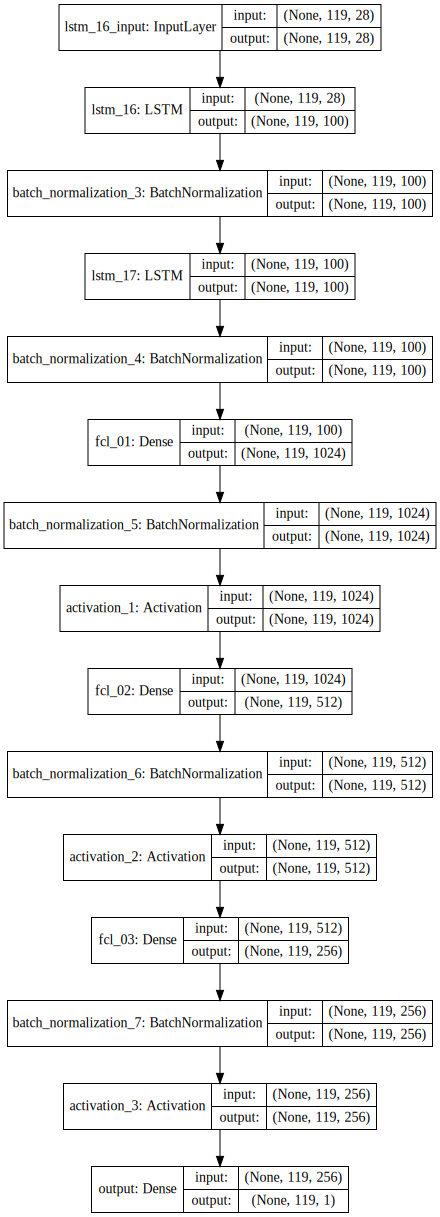

In [18]:
LSTM1_OUTPUT_DIM = 100
LSTM2_OUTPUT_DIM = 100
LSTM3_OUTPUT_DIM = 100
FC1_OUTPUT_DIM = 1024
FC2_OUTPUT_DIM = 512
FC3_OUTPUT_DIM = 256
OUTPUT_DIM = 1


def create_model(lstm1_out=LSTM1_OUTPUT_DIM, 
                 lstm2_out=LSTM2_OUTPUT_DIM, 
                 lstm3_out=LSTM3_OUTPUT_DIM, 
                 fc1_out=FC1_OUTPUT_DIM,
                 fc2_out=FC2_OUTPUT_DIM, 
                 fc3_out=FC3_OUTPUT_DIM,
                 out=OUTPUT_DIM):
    model = Sequential()
    model.add(LSTM(lstm1_out, batch_input_shape=(None, 119, 28), return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(lstm2_out, return_sequences=True))
    model.add(BatchNormalization())
#     model.add(LSTM(lstm3_out, return_sequences=True))
    model.add(Dense(fc1_out, name='fcl_01'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(fc2_out, name='fcl_02'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(fc3_out, name='fcl_03'))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    model.add(Dense(OUTPUT_DIM, name='output'))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model


def create_model2(lstm_out):
    return create_model(lstm1_out=lstm_out, 
                        lstm2_out=lstm_out,
                        lstm3_out=lstm_out)

model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Hyperparameter Optimization

In [16]:
# Custom Scorer
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, y_true.shape[1]))
    y_pred = y_pred.reshape((-1, y_pred.shape[1]))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


# Grid Search 
params = dict(lstm_out=[50, 100, 300, 500], 
              epochs=[60])

classifier = KerasClassifier(create_model2, verbose=0)
scorer = make_scorer(accuracy, greater_is_better=False) # 케라스 모델에서 MSE를 사용하기 때문에 greater_is_better는 False
grid = GridSearchCV(classifier, param_grid=params, scoring=scorer)
grid_result = grid.fit(train_x, train_padded_trend_y)

error:1.0080644451264812e-05, score:-0.7997876312525681
error:3.26339772663164e-05, score:-0.27072583569723463
error:5.5021154944915555e-05, score:-0.9042626680884613
error:1.0163722019491025e-05, score:-0.12148123258518735
error:1.0246799587717238e-05, score:-0.052824356117057825
error:3.255089969809019e-05, score:-0.07966226897239832
error:1.0080644451264812e-05, score:-0.7997876312525681
error:3.26339772663164e-05, score:-0.27072583569723463
error:5.5021154944915555e-05, score:-0.9042626680884613
error:1.0163722019491025e-05, score:-0.12148123258518735
error:1.0246799587717238e-05, score:-0.052824356117057825
error:3.255089969809019e-05, score:-0.07966226897239832
error:1.0080644451264812e-05, score:-0.7997876312525681
error:3.26339772663164e-05, score:-0.27072583569723463
error:5.5021154944915555e-05, score:-0.9042626680884613
error:1.0163722019491025e-05, score:-0.12148123258518735
error:1.0246799587717238e-05, score:-0.052824356117057825
error:3.255089969809019e-05, score:-0.0796

In [18]:
_mean_scores = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']

print('Best:', grid_result.best_params_)
for mean, std, param in zip(_mean_scores, _stds, _params):
    print(f'Mean Score:{mean:.7},\tSTD Score:{std:.5},\tParams: {param}')

Best: {'epochs': 60, 'lstm_out': 50}
Mean Score:0.5856249,	STD Score:0.37915,	Params: {'epochs': 60, 'lstm_out': 50}
Mean Score:0.5856249,	STD Score:0.37915,	Params: {'epochs': 60, 'lstm_out': 100}
Mean Score:0.5856249,	STD Score:0.37915,	Params: {'epochs': 60, 'lstm_out': 300}
Mean Score:0.5856249,	STD Score:0.37915,	Params: {'epochs': 60, 'lstm_out': 500}


# Training

In [19]:
model = create_model()
model.fit(train_x, train_padded_trend_y, epochs=1, verbose=2)

Epoch 1/1
343s - loss: 0.0061 - mean_squared_error: 0.0061


(10, 119, 28)
(32000, 119)


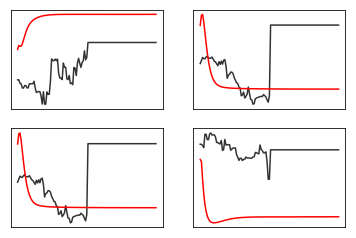

In [21]:
SIZE_X = 119


def visualize_prediction(data_x, data_y):   
    data_p = model.predict(data_x)
    
    
    data_y = data_y.reshape((-1, SIZE_X))
    data_p = data_p.reshape((-1, SIZE_X))
    
    print(data_x.shape)
    print(data_y.shape)
    
#     print('Mean Squared Error:', accuracy(data_y, data_p))
    
    fig, sub_plots = subplots(2, 2)
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            idx = np.random.randint(data_x.shape[0])
            
            sp.plot(data_y[idx], color='#333333')
            sp.plot(data_p[idx], color='red')
        
visualize_prediction(test_x[0:10], train_padded_trend_y)